In [1]:
model_paths = '../output/ablation-mnist-models/*/*.pkl'
relu_path = '../output/ablation-mnist-models/attempt0/relu.pkl'
all_modifications_path = '../output/ablation-mnist-models/attempt0/relog-elliptical-maxout_4-bce-max_fit_l1-overlay.pkl'

# Preparation

In [2]:
import sys
sys.path.append('..')

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

In [4]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [5]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=False,
            transform=torchvision.transforms.ToTensor(), 
        )

In [6]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
x, y = next(iter(loader))

In [7]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return batch * stds + means

cifar_classes = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck',
}

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')
            
    def plot_predictions(self, model, name=None, ax=None):
        name = name or model.name
        model.eval()
        preds, _ = model(self.xs)
        preds = softmax_dim1(preds)
        # because many classes have the same zero prob, we need an additional criteria to
        # choose one that makes the most sense
        mass = preds.sum(axis=0)
        preds_on_true_image, preds_on_noise = preds[0], preds[-1].clone()
        c0, c1 = sorted(range(preds.shape[1]), key=lambda i: (-preds_on_true_image[i], -mass[i]))[:2]
        remaining_indices = [i for i in range(preds.shape[1]) if i not in (c0, c1)]
        c2, c3 = sorted(remaining_indices, key=lambda i: (-preds_on_noise[i], -mass[i]))[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            if self.is_cifar:
                class_name = cifar_classes[c]
            else:
                class_name = str(c)
            (ax or plt).plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %s' %class_name)
        if ax is None: 
            plt.ylim(0, 1)
            plt.title('Model: ' + name)
        else:
            ax.set_ylim(0, 1)
            ax.set_title('Model: ' + name)
        (ax or plt).legend()

In [8]:
def compare_visually(model_a, model_b, idx, is_cifar=False):
    p = Plotter(idx, is_cifar=is_cifar)
    plt.ion()
    p.plot_transition()
    _, axes = plt.subplots(1, 2, figsize=(15,4))
    p.plot_predictions(model_a, ax=axes[0])
    p.plot_predictions(model_b, ax=axes[1])
    plt.ioff()

# Compare two models visually

In [9]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)
model_a.name = 'Baseline'
model_b.name = 'Proposed'

Plotting image at index 84


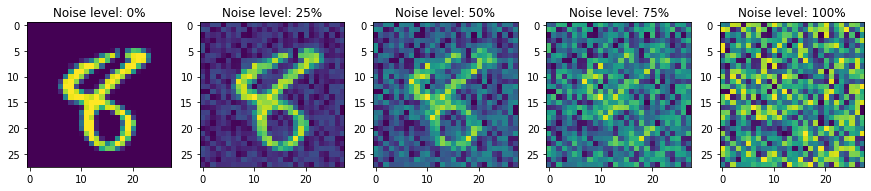

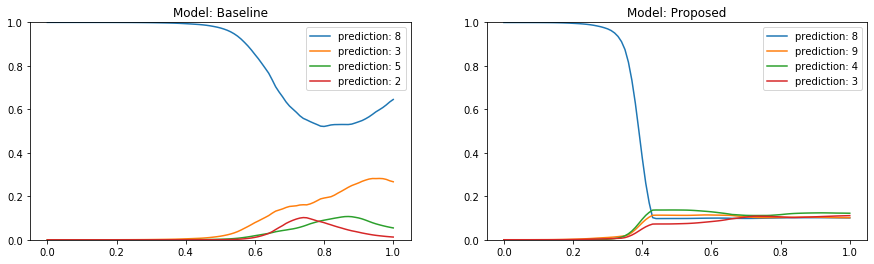

In [10]:
compare_visually(model_a, model_b, 84)

Plotting image at index 41


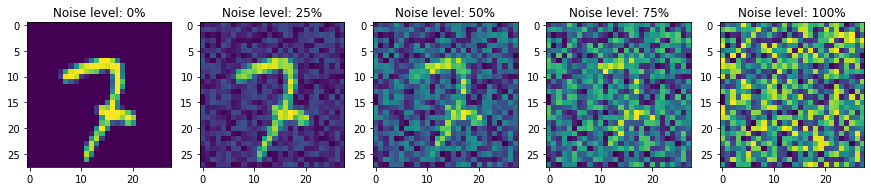

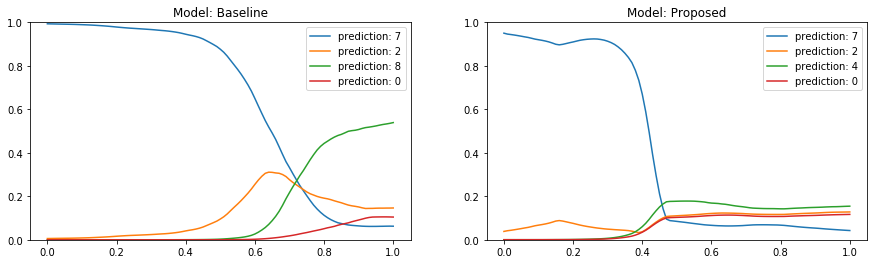

In [11]:
compare_visually(model_a, model_b, 41)

Plotting image at index 8


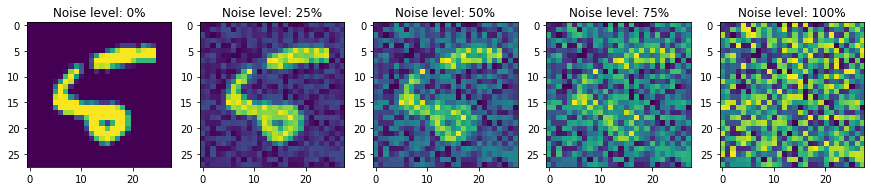

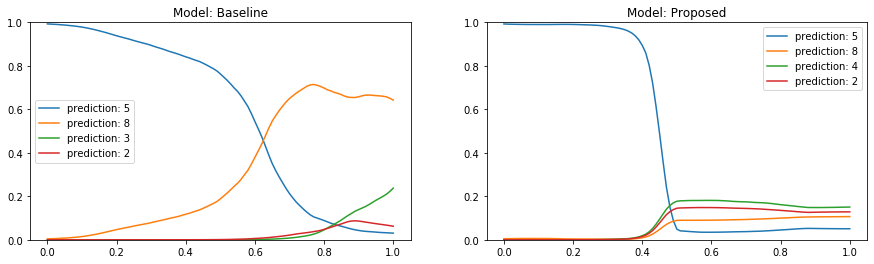

In [12]:
compare_visually(model_a, model_b, 8)

Plotting image at index 908


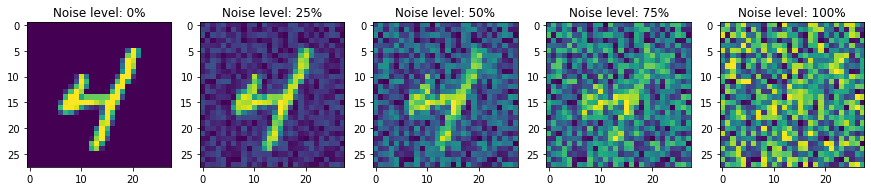

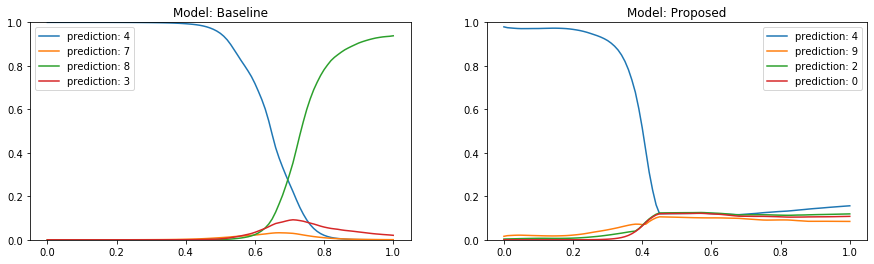

In [13]:
compare_visually(model_a, model_b, 908)

# Evaluate models

In [14]:
def evaluate(model):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)
    x, y = next(iter(loader))
    noise_images = torch.rand(*x.shape)
    
    preds_on_real, _ = model(x)
    max_probs_on_real, predicted_classes = softmax(preds_on_real, dim=1).max(dim=1)
    accuracy_on_real = (predicted_classes == y).float().mean()
    
    preds_on_noise, _ = model(noise_images)
    max_probs_on_noise, _ = softmax(preds_on_noise, dim=1).max(dim=1)
    accuracy_on_noise = (max_probs_on_noise < 0.5).float().mean()
    
    return {
        'acc_on_real': accuracy_on_real.item(),
        'prob_on_real': max_probs_on_real.mean().item(),
        'acc_on_noise': accuracy_on_noise.item(),
        'prob_on_noise': max_probs_on_noise.mean().item(),
    }

# evaluate(load_model('../output/ablation-mnist-models/attempt2/relog.pkl'))

In [18]:
results = []
with tqdm(glob(model_paths)) as progress:
    for model_path in progress:
        model = load_model(model_path)
        row = evaluate(model)
        row['path'] = model_path
        results.append(row)

100%|██████████| 90/90 [05:21<00:00,  3.57s/it]


In [20]:
results = pd.DataFrame(results)

In [24]:
results['attempt'] = results.path.str.extract(r'/attempt(\d+)/')
results['model'] = results.path.str.extract(r'/([^/]+).pkl$')

In [25]:
results.sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
78,0.945,0.844290,0.000,0.993657,../output/ablation-mnist-models/attempt7/relog...,7,relog-elliptical-maxout_4
65,0.994,0.985217,0.014,0.911905,../output/ablation-mnist-models/attempt0/relog...,0,relog-elliptical-maxout_4-max_fit_l1
22,0.990,0.989672,0.313,0.581183,../output/ablation-mnist-models/attempt4/relu.pkl,4,relu


In [64]:
results[results.model.str.contains('elliptical')].sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
83,0.993,0.985072,0.027,0.892528,../output/ablation-mnist-models/attempt9/relog...,9,relog-elliptical-maxout_4-max_fit_l1
48,0.969,0.970381,0.000,0.994117,../output/ablation-mnist-models/attempt6/relog...,6,relog-elliptical-maxout_4-bce-max_fit_l1
20,0.990,0.984314,0.001,0.981456,../output/ablation-mnist-models/attempt4/relog...,4,relog-elliptical-maxout_4-max_fit_l1


In [38]:
results.model.unique()

array(['relog', 'relog-maxout_4', 'relog-elliptical-maxout_4-max_fit_l1',
       'relog-elliptical-maxout_4-bce-max_fit_l1', 'relu',
       'relog-elliptical-maxout_4-bce-max_fit_l1-overlay',
       'relog-elliptical-maxout_4', 'relog-minmaxout_2_4',
       'relog-elliptical-bce-max_fit_l1-overlay'], dtype=object)

In [29]:
formatted_names = OrderedDict([
    ('relu', 'Baseline'),
    ('relog', '+ ReLog (beta=2)'), 
    ('relog-maxout_4', '+ MaxOut (k=4)'),
    ('relog-minmaxout_2_4', '+ MinOut (k=2)'),
    ('relog-elliptical-maxout_4', '+ Elliptical'),
    ('relog-elliptical-maxout_4-max_fit_l1', '+ MaxFit (L1)'),  
    ('relog-elliptical-maxout_4-bce-max_fit_l1', '+ BCE training'),  
    ('relog-elliptical-maxout_4-bce-max_fit_l1-overlay', '+ Negative examples'),  
])
model_order = {n: i for i, n in enumerate(formatted_names)}

In [46]:
full_summary = results.drop(columns=['attempt', 'path']).groupby('model').agg(['mean', 'std']).reset_index()
full_summary

model acc_on_real            \
                                                           mean       std   
0                                             relog      0.9892  0.001989   
1           relog-elliptical-bce-max_fit_l1-overlay      0.9469  0.050333   
2                         relog-elliptical-maxout_4      0.9517  0.012936   
3          relog-elliptical-maxout_4-bce-max_fit_l1      0.9713  0.008590   
4  relog-elliptical-maxout_4-bce-max_fit_l1-overlay      0.9544  0.025105   
5              relog-elliptical-maxout_4-max_fit_l1      0.9907  0.002584   
6                                    relog-maxout_4      0.9930  0.002582   
7                               relog-minmaxout_2_4      0.9923  0.002263   
8                                              relu      0.9927  0.002452   

  prob_on_real           acc_on_noise           prob_on_noise            
          mean       std         mean       std          mean       std  
0     0.987066  0.001383       0.0392  0.023513      0.820383  0.054001  
1     0.922514  0.103196       0.1682  0.232353      0.755212  0.177153  
2     0.855327  0.022204       0.0022  0.003676      0.960026  0.033762  
3     0.966026  0.017105       0.0000  0.000000      0.996986  0.002952  
4     0.951724  0.025313       0.9214  0.248204      0.212839  0.159012  
5     0.985235  0.001498       0.0214  0.034872      0.911608  0.073203  
6     0.989266  0.001426       0.0291  0.047101      0.874291  0.090241  
7     0.986263  0.003035       0.0438  0.047907      0.834755  0.092037  
8     0.990495  0.001450       0.2222  0.148769      0.641305  0.075844

In [37]:
summary = full_summary[full_summary.model.isin(formatted_names)]
summary['model_order'] = summary.model.apply(model_order.__getitem__)
summary = summary.sort_values(['model_order']).drop(columns='model_order')
summary['model'] = summary.model.apply(formatted_names.__getitem__)
summary = summary.reset_index(drop=True)
summary

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


model acc_on_real           prob_on_real            \
                              mean       std         mean       std   
0             Baseline      0.9927  0.002452     0.990495  0.001450   
1     + ReLog (beta=2)      0.9892  0.001989     0.987066  0.001383   
2       + MaxOut (k=4)      0.9930  0.002582     0.989266  0.001426   
3       + MinOut (k=2)      0.9923  0.002263     0.986263  0.003035   
4         + Elliptical      0.9517  0.012936     0.855327  0.022204   
5        + MaxFit (L1)      0.9907  0.002584     0.985235  0.001498   
6       + BCE training      0.9713  0.008590     0.966026  0.017105   
7  + Negative examples      0.9544  0.025105     0.951724  0.025313   

  acc_on_noise           prob_on_noise            
          mean       std          mean       std  
0       0.2222  0.148769      0.641305  0.075844  
1       0.0392  0.023513      0.820383  0.054001  
2       0.0291  0.047101      0.874291  0.090241  
3       0.0438  0.047907      0.834755  0.092037  
4       0.0022  0.003676      0.960026  0.033762  
5       0.0214  0.034872      0.911608  0.073203  
6       0.0000  0.000000      0.996986  0.002952  
7       0.9214  0.248204      0.212839  0.159012

In [47]:
formatted = summary.round(2)
formatted['acc_on_noise_str'] = formatted[('acc_on_noise', 'mean')].astype(str) + ' pm ' + formatted[('acc_on_noise', 'std')].astype(str)
formatted = formatted.drop(columns=[('prob_on_real', 'std'), 'acc_on_real', 
                                  ('prob_on_noise', 'std'), 'acc_on_noise'])
print(formatted.to_latex())

\begin{tabular}{llrrl}
\toprule
{} &                model & prob\_on\_real & prob\_on\_noise & acc\_on\_noise\_str \\
{} &         mean & \multicolumn{2}{l}{mean} \\
\midrule
0 &             Baseline &         0.99 &          0.64 &     0.22 pm 0.15 \\
1 &     + ReLog (beta=2) &         0.99 &          0.82 &     0.04 pm 0.02 \\
2 &       + MaxOut (k=4) &         0.99 &          0.87 &     0.03 pm 0.05 \\
3 &       + MinOut (k=2) &         0.99 &          0.83 &     0.04 pm 0.05 \\
4 &         + Elliptical &         0.86 &          0.96 &       0.0 pm 0.0 \\
5 &        + MaxFit (L1) &         0.99 &          0.91 &     0.02 pm 0.03 \\
6 &       + BCE training &         0.97 &          1.00 &       0.0 pm 0.0 \\
7 &  + Negative examples &         0.95 &          0.21 &     0.92 pm 0.25 \\
\bottomrule
\end{tabular}



### Previous result (2019)

```
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))
    
relu.pkl: 0.28 (std=0.05)
relog.pkl: 0.06 (std=0.03)
relu-maxout.pkl: 0.05 (std=0.02)
relu-minmaxout.pkl: 0.02 (std=0.01)
relu-elliptical.pkl: 0.01 (std=0.01)
relu-max_fit_l1.pkl: 0.48 (std=0.05)
relu-mse.pkl: 0.08 (std=0.03)
relu-mse-overlay.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-maxout_4-max_fit_l1.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit-maxout.pkl: 0.79 (std=0.04)
relu-elliptical-maxout.pkl: 0.03 (std=0.02)
```

In [96]:
# check if the architecture is correct
load_model(relu_elliptical_maxout_path)

CNN(
  (features): Sequential(
    (0): EllipticalCNN(
      1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): EllipticalCNN(
      16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (_quadratic): AbsConv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    )
    (5): FoldingMaxout(use_min=False, k=4)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Elliptical(
      in_features=1568, out_features=40, bias=True
      (_quadratic): AbsLinear(in_features=1568, out_features=40, bias=False)
    )
    (1): FoldingMaxout(use_min=False, k=4)
  )
)

## Examining some models

In [42]:
relu_elliptical_maxfit_maxout = load_model(relu_elliptical_maxfit_maxout_path)
relu_elliptical_maxfit_maxout.name = 'Elliptical + MaxFit + MaxOut'

Plotting image at index 223


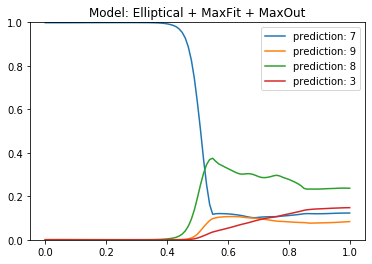

In [43]:
p = Plotter(223)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 5898


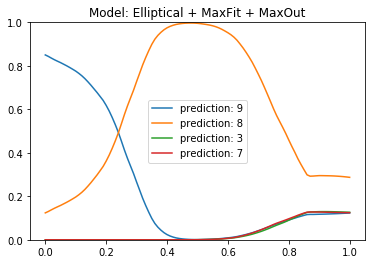

In [44]:
p = Plotter(5898)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 6753


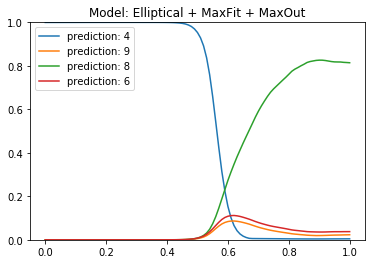

In [45]:
p = Plotter(6753)
p.plot_predictions(relu_elliptical_maxfit_maxout)

Plotting image at index 4148


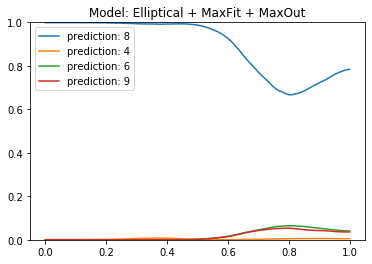

In [46]:
p = Plotter(4148)
p.plot_predictions(relu_elliptical_maxfit_maxout)

# CIFAR-10 models

In [39]:
cifar10_baseline_path = '../output/ablation-cifar10-models/relu.pkl'
cifar10_modified_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit.pkl'
cifar10_modified_with_bce_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce.pkl'
cifar10_modified_with_overlay_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce-overlay.pkl'

In [41]:
cifar10_model_a = load_model(cifar10_baseline_path)
cifar10_model_b = load_model(cifar10_modified_path)
cifar10_model_c = load_model(cifar10_modified_with_bce_path)
cifar10_model_d = load_model(cifar10_modified_with_overlay_path)

In [64]:
cifar10_model_a.name = 'Baseline'
cifar10_model_b.name = 'Proposed (no BCE)'
cifar10_model_d.name = 'Proposed (BCE+Overlay)'

In [13]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [14]:
x, y = next(iter(cifar10_testloader))

In [71]:
p = Plotter(3, is_cifar=True)

Plotting image at index 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


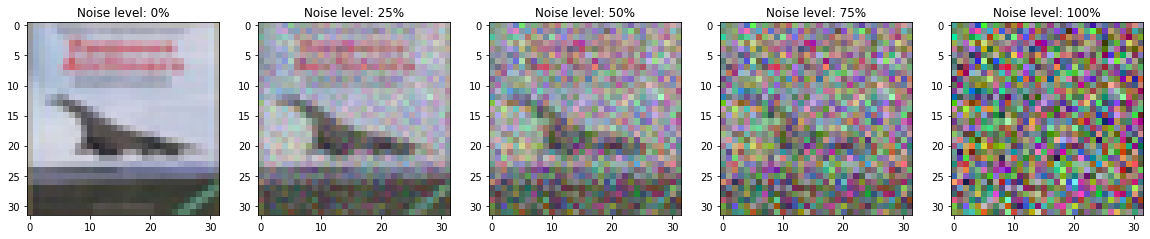

In [72]:
p.plot_transition()

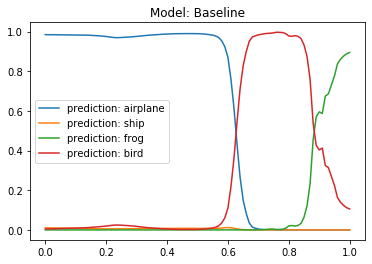

In [73]:
p.plot_predictions(cifar10_model_a)

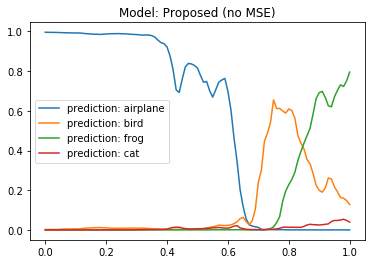

In [74]:
p.plot_predictions(cifar10_model_b)

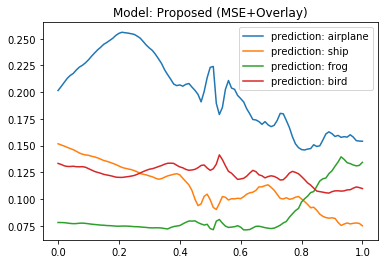

In [75]:
p.plot_predictions(cifar10_model_d)

In [76]:
p = Plotter(138, is_cifar=True)

Plotting image at index 138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


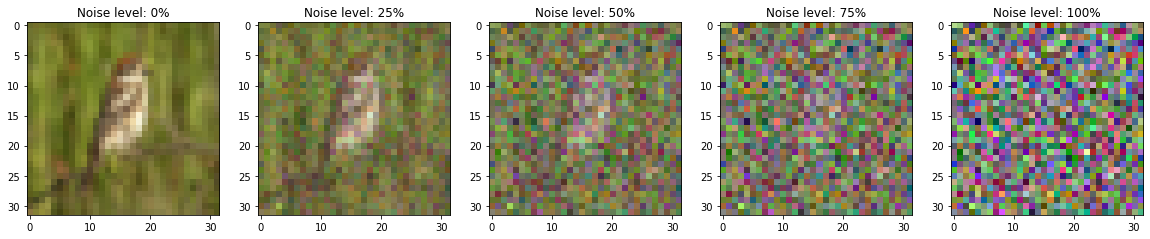

In [77]:
p.plot_transition()

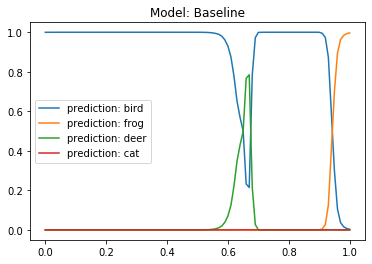

In [78]:
p.plot_predictions(cifar10_model_a)

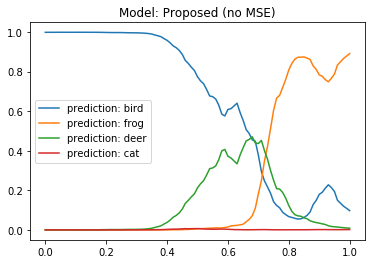

In [79]:
p.plot_predictions(cifar10_model_b)

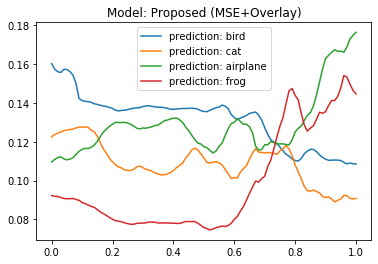

In [80]:
p.plot_predictions(cifar10_model_d)

In [81]:
p = Plotter(118, is_cifar=True)

Plotting image at index 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


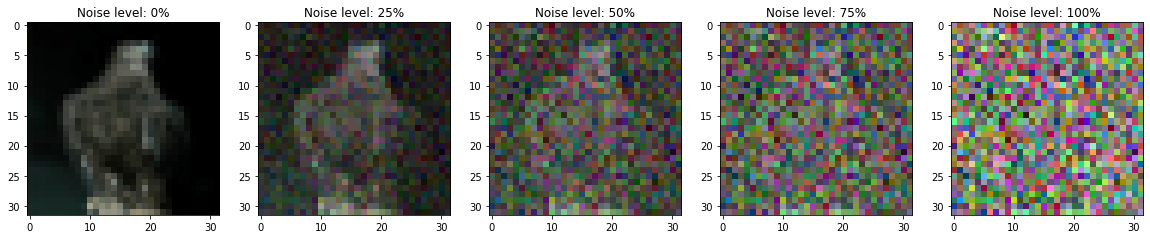

In [82]:
p.plot_transition()

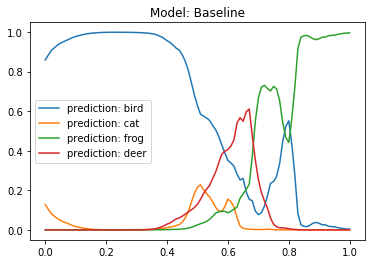

In [83]:
p.plot_predictions(cifar10_model_a)

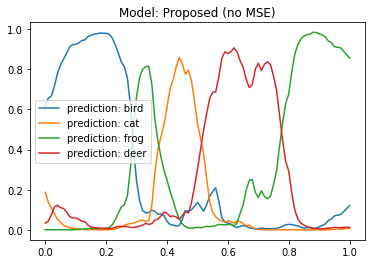

In [85]:
p.plot_predictions(cifar10_model_b)

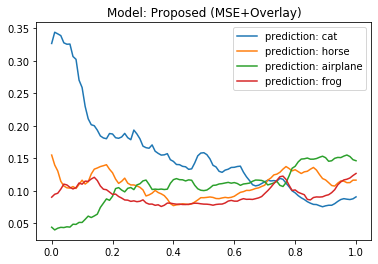

In [84]:
p.plot_predictions(cifar10_model_d)

In [66]:
p = Plotter(197, is_cifar=True)

Plotting image at index 197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


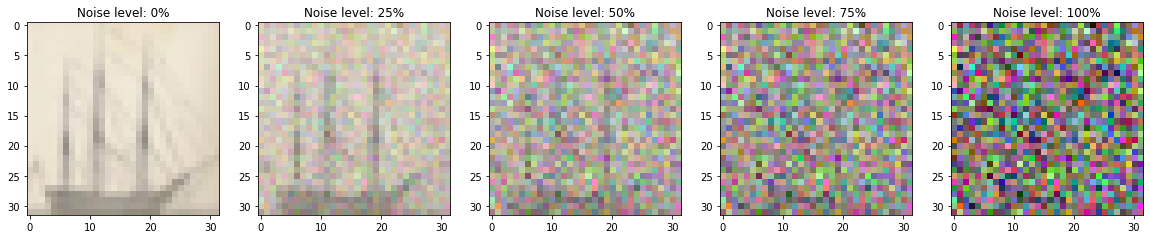

In [67]:
p.plot_transition()

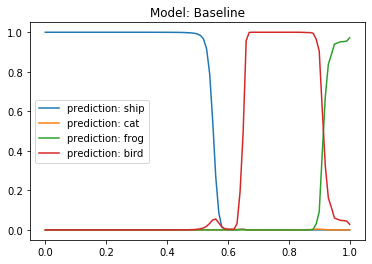

In [68]:
p.plot_predictions(cifar10_model_a)

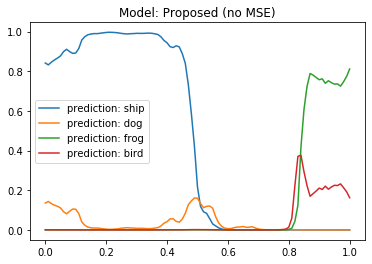

In [69]:
p.plot_predictions(cifar10_model_b)

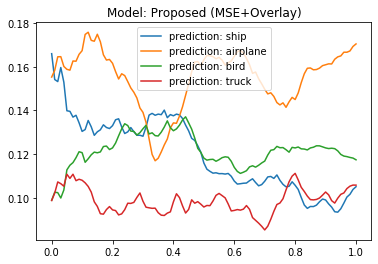

In [70]:
p.plot_predictions(cifar10_model_d)

## Measure accuracy on noise

In [36]:
noise_images = torch.randn(1000, 3, 32, 32) # used in measure_accuracy_on_noise()

In [40]:
measure_accuracy_on_noise(cifar10_model_a)

(tensor(0.), tensor(0.))

In [53]:
measure_accuracy_on_noise(cifar10_model_b)

(tensor(0.0530), tensor(0.0200))

In [41]:
measure_accuracy_on_noise(cifar10_model_c)

(tensor(0.0560), tensor(0.0284))

In [43]:
measure_accuracy_on_noise(cifar10_model_d)

(tensor(1.), tensor(0.))

## Measure max propbability

In [37]:
from scipy import stats

def compare_max_probs_on_noise(model1, model2):
    preds1, _ = model1(noise_images)
    max_probs1, _ = softmax(preds1, dim=1).max(dim=1)
    print('Model1: mean=%f, std=%f' %(max_probs1.mean().item(), max_probs1.std().item()))
    
    preds2, _ = model2(noise_images)
    max_probs2, _ = softmax(preds2, dim=1).max(dim=1)
    print('Model2: mean=%f, std=%f' %(max_probs2.mean().item(), max_probs2.std().item()))

    _, p_value = stats.ttest_ind(max_probs1.detach().numpy(), max_probs2.detach().numpy())
    print('p-value:', p_value)
    return max_probs1.mean(), max_probs2.mean()

In [38]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_b)

Model1: mean=0.933567, std=0.115321
Model2: mean=0.793023, std=0.159887
p-value: 1.8384115221932228e-100


(tensor(0.9336, grad_fn=<MeanBackward0>),
 tensor(0.7930, grad_fn=<MeanBackward0>))

In [43]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_c)

Model1: mean=0.933080, std=0.116153
Model2: mean=0.810416, std=0.161094
p-value: 6.896738755809479e-78


(tensor(0.9331, grad_fn=<MeanBackward0>),
 tensor(0.8104, grad_fn=<MeanBackward0>))

In [42]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_d)

Model1: mean=0.933567, std=0.115321
Model2: mean=0.163738, std=0.012626
p-value: 0.0


(tensor(0.9336, grad_fn=<MeanBackward0>),
 tensor(0.1637, grad_fn=<MeanBackward0>))

## Check the overlay model

The BCE+Overlay model seems to perform well on noise but actually it always give low probability everywhere and only predict accurately in 43% cases. Let's see if there's any difference between actual images and noise...?

In [87]:
preds, _ = cifar10_model_d(x)
max_probs, _ = softmax(preds, dim=1).max(dim=1)
(max_probs.mean().item(), max_probs.std().item())

(0.211810901761055, 0.10155008733272552)